In [24]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

EPOCHS = 3000
BATCH_SIZE = 8
LEARNING_RATE = 0.003


In [25]:
TRAIN_DATA_PATH = "./cnn_data/train"
TEST_DATA_PATH = "./cnn_data/test"
TRANSFORM_IMG = transforms.Compose([
    transforms.ToTensor()
    ])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader=test_loader

classes=list(test_data.class_to_idx.keys())
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 10000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Validation
n_val_samples = 100
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 1000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))


def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

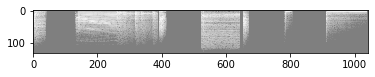

  rim noise snare  clap hihat_open  clap  kick   tom


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [27]:
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.autograd import Variable
import torch.nn.functional as F

class CNN_net(torch.nn.Module):
    
    #Our batch shape for input x is (3, 128, 128)
    
    def __init__(self):
        super(CNN_net, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18*64*64, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 19)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 32, 32) to (18, 16, 16)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18*64*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)




In [28]:
#io calculator
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    print(output)
# outputSize(128*128*3,kernel_size=2, stride=2, padding=0)


In [29]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
#     train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
#             inputs, labels = data[0], data[1]
            inputs, labels = data[0].to(device), data[1].to(device)
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data
            total_train_loss += loss_size.data
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels = inputs.to(device), labels.to(device)
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [ ]:
CNN = CNN_net()
CNN.to(device)
trainNet(CNN, batch_size=BATCH_SIZE, n_epochs=1000, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 8
epochs= 1000
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.69 took: 0.83s
Epoch 1, 20% 	 train_loss: 2.07 took: 0.73s
Epoch 1, 30% 	 train_loss: 1.79 took: 0.74s
Epoch 1, 40% 	 train_loss: 1.58 took: 0.73s
Epoch 1, 50% 	 train_loss: 1.57 took: 0.73s
Epoch 1, 60% 	 train_loss: 1.54 took: 0.73s
Epoch 1, 70% 	 train_loss: 1.47 took: 0.73s
Epoch 1, 80% 	 train_loss: 1.43 took: 0.74s
Epoch 1, 90% 	 train_loss: 1.40 took: 0.73s
Validation loss = 1.36
Epoch 2, 10% 	 train_loss: 1.31 took: 0.85s
Epoch 2, 20% 	 train_loss: 1.23 took: 0.74s
Epoch 2, 30% 	 train_loss: 1.24 took: 0.74s
Epoch 2, 40% 	 train_loss: 1.26 took: 0.74s
Epoch 2, 50% 	 train_loss: 1.27 took: 0.74s
Epoch 2, 60% 	 train_loss: 1.19 took: 0.74s
Epoch 2, 70% 	 train_loss: 1.22 took: 0.74s
Epoch 2, 80% 	 train_loss: 1.18 took: 0.74s
Epoch 2, 90% 	 train_loss: 1.20 took: 0.73s
Validation loss = 1.22
Epoch 3, 10% 	 train_loss: 1.09 took: 0.83s
Epoch 3, 20% 	 train_loss: 1.10 took: 0.74

In [ ]:
PATH = './1000epoch.pth'
torch.save(net.state_dict(), PATH)

dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

dimg=images.to(device)
outputs=CNN(dimg)
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(BATCH_SIZE)))